In [1115]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
import warnings
warnings.filterwarnings('ignore')

In [1116]:
ci = pd.read_csv('data/consumer-index.csv')
prices = pd.read_csv('data/producer-price-global.csv')
xchange = pd.read_csv('data/exchange-rates.csv')


In [1117]:
xchange

,Domain Code,Domain,Area Code (M49),Area,ISO Currency Code (FAO),Currency,Element Code,Element,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PE,Exchange rates,4,Afghanistan,AFA,Afghani,LCU,Local currency units per USD,2000,2000,7001,January,NaN,47357.574730,X,Figure from international organizations
1,PE,Exchange rates,4,Afghanistan,AFA,Afghani,LCU,Local currency units per USD,2000,2000,7002,February,NaN,47357.574730,X,Figure from international organizations
2,PE,Exchange rates,4,Afghanistan,AFA,Afghani,LCU,Local currency units per USD,2000,2000,7003,March,NaN,47357.574730,X,Figure from international organizations
3,PE,Exchange rates,4,Afghanistan,AFA,Afghani,LCU,Local currency units per USD,2000,2000,7004,April,NaN,47357.574730,X,Figure from international organizations
4,PE,Exchange rates,4,Afghanistan,AFA,Afghani,LCU,Local currency units per USD,2000,2000,7005,May,NaN,47357.574730,X,Figure from international organizations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27102,PE,Exchange rates,887,Yemen,YER,Yemeni Rial,LCU,Local currency units per USD,2023,2023,7003,March,NaN,1241.790323,X,Figure from international organizations
27103,PE,Exchange rates,887,Yemen,YER,Yemeni Rial,LCU,Local currency units per USD,2023,2023,7004,April,NaN,1189.183333,X,Figure from international organizations
27104,PE,Exchange rates,887,Yemen,YER,Yemeni Rial,LCU,Local currency units per USD,2023,2023,7005,May,NaN,1273.241935,X,Figure from international organizations
27105,PE,Exchange rates,887,Yemen,YER,Yemeni Rial,LCU,Local currency units per USD,2023,2023,7006,June,NaN,1348.583333,X,Figure from international organizations


In [1118]:
ITEM = 'Wheat'

In [1119]:

class DataProcesser:

    def __init__(self, df):
        self.df = df
        self.stats = None

    def subset_data(self, item, country, item_col='Item', area_col='Area'):       
        self.df = self.df[(self.df[item_col] == item) & (self.df[area_col] == country)]
       
        return self

    def convert_to_date(self, year_col='Year', month_col='Months'):
        self.df[year_col] = self.df[year_col].astype(str)
        self.df[month_col] = self.df[month_col].astype(str)
        self.df['Date'] = pd.to_datetime(self.df[year_col] + '-' + self.df[month_col])
        return self

    def get_date_and_value(self, date_col='Date', value_col='Value'):
        self.df = self.df[[date_col, value_col]].set_index(date_col)
        mean = self.df.describe().loc['mean'][0]
        std = self.df.describe().loc['std'][0]

        self.stats = {
            'mean' : mean,
            'std' : std
            }           
        
        return self
    
class DataManager:
    def __init__(self):
        self.data_processors = {}

    def process_data_for_country(self, raw_data, country, item=ITEM):
        dp = DataProcesser(raw_data)
        dp.subset_data(item, country).convert_to_date().get_date_and_value()
        self.data_processors[country] = dp
        return dp  # Optionally return the DataProcesser instance

    def get_data_processor(self, country):
        return self.data_processors[country]
        
    def get_all_dataframes(self):
         return [{country: processor.df} for country, processor in self.data_processors.items()]




# EUROPE

In [1147]:
# Usage example:
data_manager = DataManager()

# Process and store DataProcesser instances
germany_dp = data_manager.process_data_for_country(prices, 'Germany')
belgium_dp = data_manager.process_data_for_country(prices, 'Belgium')
spain_dp = data_manager.process_data_for_country(prices, 'Spain')
italy_dp = data_manager.process_data_for_country(prices, 'Italy')



germany_wheat_prices= data_manager.get_data_processor('Germany').df
belgium_wheat_prices = data_manager.get_data_processor('Belgium').df
spain_wheat_prices = data_manager.get_data_processor('Spain').df
italy_wheat_prices = data_manager.get_data_processor('Italy').df


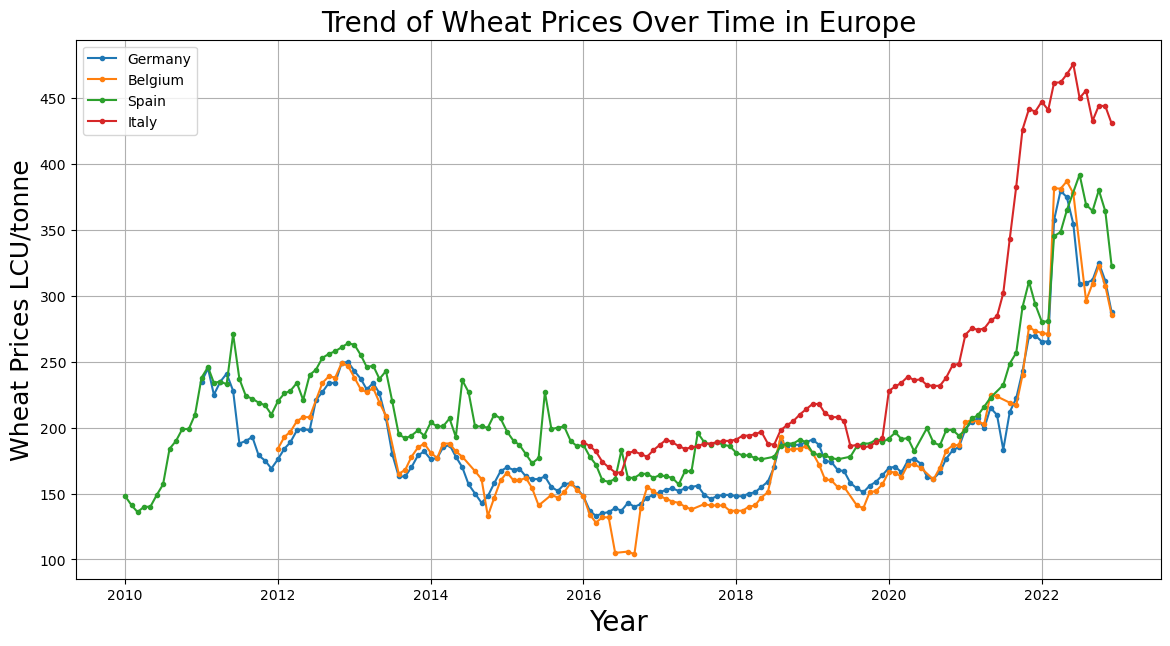

In [1153]:
import matplotlib.pyplot as plt

def plot_lines(dfs, title, xlabel, ylabel):
    plt.figure(figsize=(14, 7))

    for country, df in dfs.items():
        plt.plot(df.index, df, marker='.', label=country)

    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=18)
    plt.grid(True)
    plt.legend()

    # Only call plt.show() after all lines have been added
    plt.show()

all_wheat_prices = data_manager.get_all_dataframes()
# Usage:
all_data = {}
for country_data in all_wheat_prices:
    for country, df in country_data.items():
        all_data[country] = df

plot_lines(all_data, 'Trend of Wheat Prices Over Time in Europe', 'Year', 'Wheat Prices LCU/tonne')

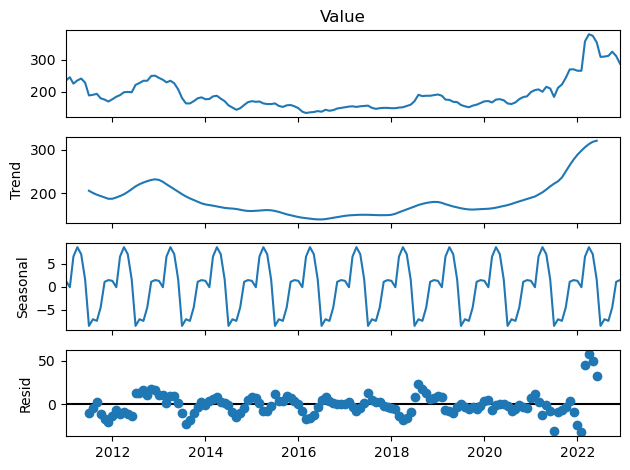

In [786]:
# plot seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomposition(df):
    
    decomposition = seasonal_decompose(df['Value'], model='additive', period=12)
    fig = decomposition.plot()
    plt.show()

seasonal_decomposition()    


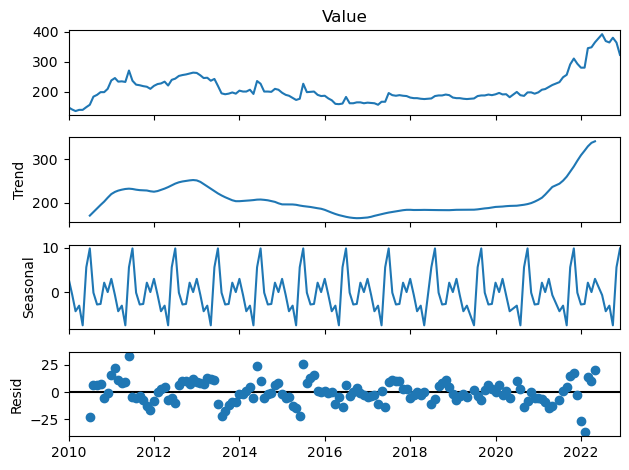

In [787]:
seasonal_decomposition(wheat_spain)

In [788]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

def perform_adfuller_test(series):
    dftest = adfuller(series, autolag='AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

#Usage:
perform_adfuller_test(wheat_germany['Value'])


1. ADF :  -0.21108363556987864
2. P-Value :  0.9371875175556861
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 135
5. Critical Values :
	 1% :  -3.479742586699182
	 5% :  -2.88319822181578
	 10% :  -2.578319684499314


In [789]:
# convert from stationary to non-stationary
def differencing(series, interval=1):
    return series.diff(interval)
  
# #Usage:
#cpfi_pakistan_diff = differencing(cpfi_pakistan['Value'])

In [790]:
# take log of the series
def log_transform(series):
    return np.log(series)

#Usage:
wheat_germany['Value'] = log_transform(wheat_germany['Value'])
wheat_spain['Value'] = log_transform(wheat_spain['Value'])

# take diff also
wheat_germany['Value'] = differencing(wheat_germany['Value']).dropna()
wheat_spain['Value'] = differencing(wheat_spain['Value']).dropna()




In [791]:
wheat_spain.dropna(inplace=True)
wheat_germany.dropna(inplace=True)

1. ADF :  -5.155000811736372
2. P-Value :  1.0855554665065604e-05
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 135
5. Critical Values :
	 1% :  -3.479742586699182
	 5% :  -2.88319822181578
	 10% :  -2.578319684499314


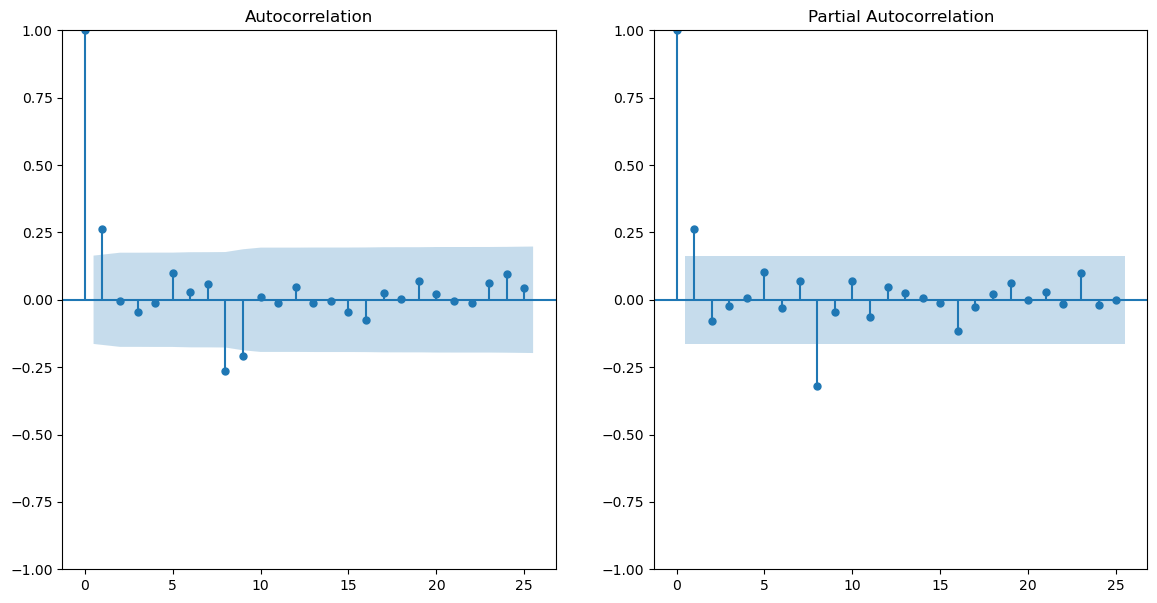

In [792]:
perform_adfuller_test(wheat_germany['Value'])

# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    plot_acf(series, lags=lags, ax=ax[0])
    plot_pacf(series, lags=lags, ax=ax[1])
    plt.show()

#Usage:
plot_acf_pacf(wheat_germany['Value'], 25)




In [793]:
def generate_predictions(last_date_in_data, pred_future, periods,  country):
    if isinstance(last_date_in_data, str):
        last_date_in_data = pd.to_datetime(last_date_in_data)

    # Generate a date range starting the first day of the next month after last_date_in_data
    # 'MS' stands for month start frequency
    future_dates = pd.date_range(start=last_date_in_data + pd.offsets.MonthBegin(1), periods=periods, freq='MS')
    # Create the predictions DataFrame with the pred_future list
    predictions = pd.DataFrame(pred_future, columns=['Predicted'])
    # Assign these dates as the index to the predictions DataFrame
    predictions.index = future_dates
    predictions.index.name = 'Date'

    predictions = (predictions["Predicted"] * wheat_stats[country]['std'])  + wheat_stats[country]['mean']

    return predictions

In [794]:
X = wheat_germany['Value'].dropna().values

In [795]:
train = X[:len(X)-7]
test = X[len(X)-7:]

model_germany = AutoReg(train, lags=20).fit()

print(model_germany.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  136
Model:                    AutoReg(20)   Log Likelihood                 199.623
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Mon, 12 Feb 2024   AIC                           -355.247
Time:                        10:04:19   BIC                           -294.668
Sample:                            20   HQIC                          -330.655
                                  136                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.004      0.747      0.455      -0.005       0.011
y.L1           0.3781      0.093      4.075      0.000       0.196       0.560
y.L2          -0.0488      0.097     -0.501      0.6

In [796]:
pred_germany = model_germany.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

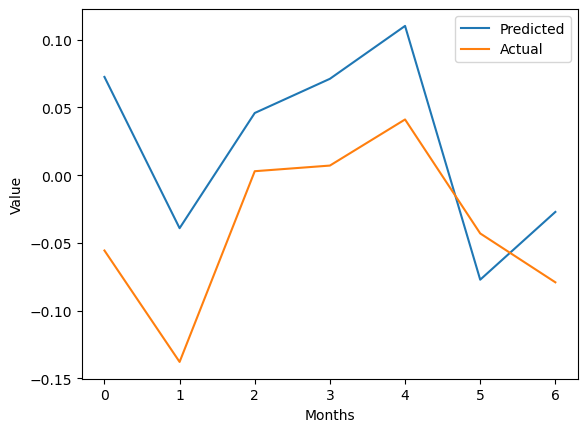

In [797]:
# import pyplot
from matplotlib import pyplot
pyplot.plot(pred_germany, label='Predicted')
pyplot.plot(test, label='Actual')

pyplot.xlabel('Months')
pyplot.ylabel('Value')

pyplot.legend()

In [798]:
# Calculate the mean squared erro
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, pred_germany))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.076


In [799]:
# future prediction
pred_future_germany = model_germany.predict(start=len(X)+1, end=len(X)+24, dynamic=False)
print("The future prediction for the next 7 days is:")
print(pred_future_germany)
print("Numbeer of predictions made: ", len(pred_future_germany))

The future prediction for the next 7 days is:
[-0.08357208  0.07298639  0.09287388  0.0273359  -0.02892424  0.01961526
  0.07478581 -0.0690332   0.1411298   0.07778384 -0.07700917  0.01946099
  0.03519647  0.04595386 -0.01792502  0.11352179 -0.00926125 -0.10341583
  0.10458969  0.01417145  0.0009444   0.03435172  0.06002273 -0.04017136]
Numbeer of predictions made:  24


In [800]:
last_date_in_data = wheat_germany.index.max()

In [801]:
wheat_stats

{'Germany': {'mean': 190.83402777777778, 'std': 50.84658560394829},
 'Spain': {'mean': 211.50198675496688, 'std': 50.32221705529104}}

In [802]:
predictions_germany = generate_predictions(last_date_in_data, pred_future_germany, 24, 'Germany')

# Spain

In [803]:
perform_adfuller_test(wheat_spain['Value'])

1. ADF :  -3.523156102718103
2. P-Value :  0.007411934503616701
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 138
5. Critical Values :
	 1% :  -3.47864788917503
	 5% :  -2.882721765644168
	 10% :  -2.578065326612056


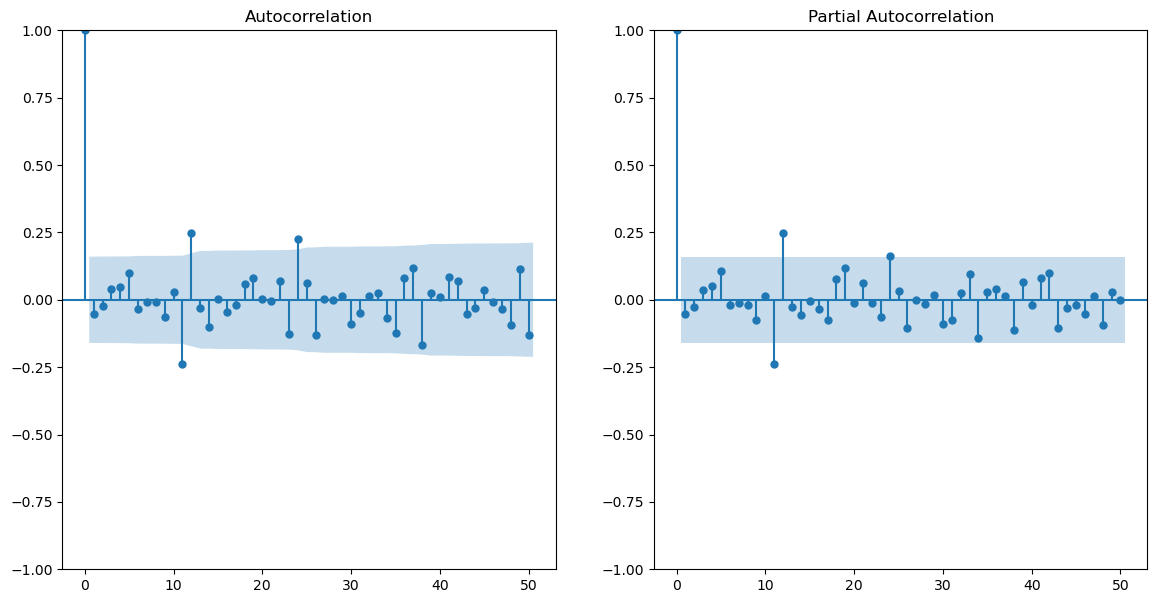

In [804]:
plot_acf_pacf(wheat_spain['Value'], 50)

In [805]:
X = wheat_spain['Value'].dropna().values

In [806]:
train = X[:len(X)-7]
test = X[len(X)-7:]

model_spain = AutoReg(train, lags=50).fit()

print(model_spain.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  143
Model:                    AutoReg(50)   Log Likelihood                 163.778
Method:               Conditional MLE   S.D. of innovations              0.042
Date:                Mon, 12 Feb 2024   AIC                           -223.556
Time:                        10:04:20   BIC                            -91.861
Sample:                            50   HQIC                          -170.381
                                  143                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0135      0.005      2.479      0.013       0.003       0.024
y.L1          -0.1329      0.104     -1.274      0.203      -0.337       0.072
y.L2           0.0552      0.114      0.486      0.6

In [807]:
pred_spain = model_spain.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

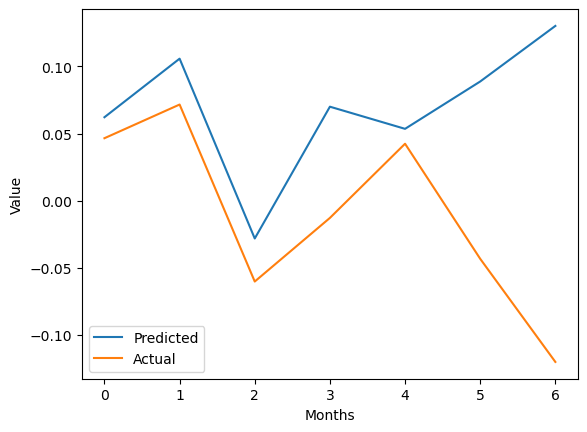

In [808]:
# import pyplot
from matplotlib import pyplot
pyplot.plot(pred_spain, label='Predicted')
pyplot.plot(test, label='Actual')

pyplot.xlabel('Months')
pyplot.ylabel('Value')

pyplot.legend()

In [809]:
# Calculate the mean squared erro

rmse = np.sqrt(mean_squared_error(test, pred_spain))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.113


In [810]:
# future prediction
pred_future_spain = model_spain.predict(start=len(X)+1, end=len(X)+24, dynamic=False)
print("The future prediction for the next 7 days is:")
print(pred_future_spain)
print("Numbeer of predictions made: ", len(pred_future_spain))


The future prediction for the next 7 days is:
[0.03926146 0.00326757 0.13325299 0.11058497 0.10323404 0.11890146
 0.08627089 0.08157568 0.09805282 0.12580305 0.16210286 0.11399176
 0.09694957 0.07955722 0.19559572 0.16719803 0.17370724 0.22185153
 0.19010579 0.14731024 0.16022944 0.24159282 0.27335167 0.2128226 ]
Numbeer of predictions made:  24


In [811]:
last_date_in_data = wheat_spain.index.max()


In [812]:
predictions_spain = generate_predictions(last_date_in_data, pred_future_spain, 24, country='Spain')

In [814]:
predictions_germany

Date
2023-01-01    186.584673
2023-02-01    194.545136
2023-03-01    195.556348
2023-04-01    192.223965
2023-05-01    189.363329
2023-06-01    191.831397
2023-07-01    194.636631
2023-08-01    187.323925
2023-09-01    198.009996
2023-10-01    194.789071
2023-11-01    186.918374
2023-12-01    191.823553
2024-01-01    192.623648
2024-02-01    193.170625
2024-03-01    189.922601
2024-04-01    196.606223
2024-05-01    190.363125
2024-06-01    185.575686
2024-07-01    196.152056
2024-08-01    191.554597
2024-09-01    190.882048
2024-10-01    192.580696
2024-11-01    193.885978
2024-12-01    188.791452
Freq: MS, Name: Predicted, dtype: float64

In [815]:
predictions_spain

Date
2023-01-01    213.477710
2023-02-01    211.666418
2023-03-01    218.207573
2023-04-01    217.066867
2023-05-01    216.696953
2023-06-01    217.485372
2023-07-01    215.843329
2023-08-01    215.607056
2023-09-01    216.436222
2023-10-01    217.832675
2023-11-01    219.659362
2023-12-01    217.238305
2024-01-01    216.380704
2024-02-01    215.505482
2024-03-01    221.344797
2024-04-01    219.915763
2024-05-01    220.243320
2024-06-01    222.666047
2024-07-01    221.068532
2024-08-01    218.914965
2024-09-01    219.565087
2024-10-01    223.659473
2024-11-01    225.257649
2024-12-01    222.211692
Freq: MS, Name: Predicted, dtype: float64

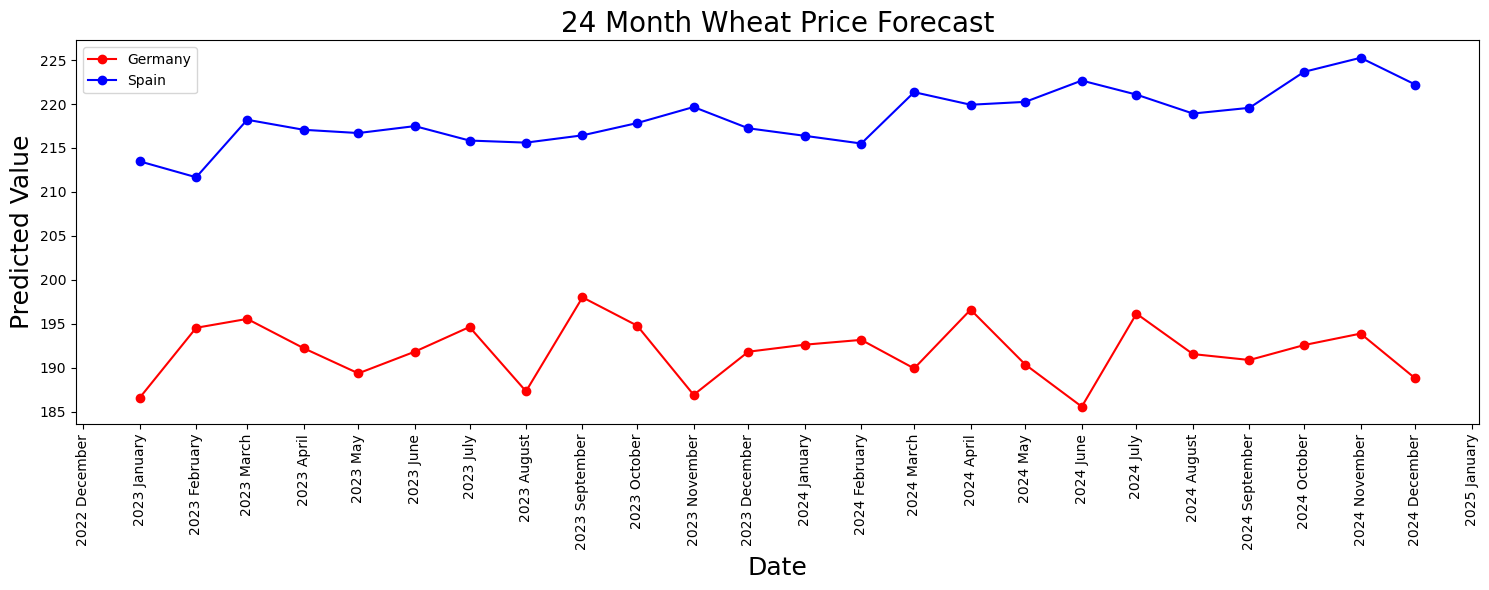

In [816]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_predictions(predictions, title='24 Month Wheat Price Forecast', xlabel='Date', ylabel='Predicted Value'):
    # Ensure that 'predictions' has a DateTime index

    # Plot the predictions
    plt.figure(figsize=(15,6))
    for prediction, label, color in predictions:
        plt.plot(prediction.index, prediction, label=label, color=color, marker='o')

    # Define the date format
    date_format = mdates.DateFormatter('%Y %B') 
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Add title and labels
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    # Show legend
    plt.legend()

    # Rotate the date labels for better readability
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()  
    plt.show()


predictions = [
    (predictions_germany, 'Germany', 'red'),
    (predictions_spain, 'Spain', 'blue')
]
plot_predictions(predictions)